In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

%matplotlib inline

# EIT Cooling

$\Gamma$ Type level structure

## rate equation result

# Fock State

In [2]:
def Amp(omega_g,omega_r,gamma,nu,detuning,sign="+"):
    if sign=="+":
        return (omega_g/gamma)**2*(gamma*nu**2/(nu**2+4*(omega_r**2/4-nu*(nu-detuning))**2/gamma**2))
    elif sign=="-":
        return (omega_g/gamma)**2*(gamma*nu**2/(nu**2+4*(omega_r**2/4-nu*(nu+detuning))**2/gamma**2))
    else:
        return
def ns(omega_g,omega_r,gamma,nu,detuning):
    Ap = Amp(omega_g,omega_r,gamma,nu,detuning,sign="+")
    Am = Amp(omega_g,omega_r,gamma,nu,detuning,sign="-")
    return (Ap)/(Am-Ap)

\begin{equation}
\frac{d}{dt}\langle n\rangle = -\eta^2 (A_--A_+)\langle n\rangle+\eta^2 A_+
\end{equation}
Thus:
\begin{equation}
\langle n\rangle = \frac{A_+}{A_--A_+}(1-e^{-\eta^2(A_--A_+)t})+C_0e^{-\eta^2(A_--A_+)t}
\end{equation}

$\eta$ is the Lamb-Dicke parameter, defined as $\eta = |k_g-k_r|a_0$ with $a_0$ rms size of the ground state of the harmonic oscillator

In [21]:
gamma = np.pi*2*20*1e6
omega_r = gamma
omega_g = gamma/20
nu = gamma/10
eta = 0.145
detuning = 2.5*gamma
tlist = np.linspace(0,2,500)*1e5/gamma
Ap = Amp(omega_g,omega_r,gamma,nu,detuning,sign="+")
Am = Amp(omega_g,omega_r,gamma,nu,detuning,sign="-")
def nbar_list(initial_motional_state):
    nbarlist = (Ap)/(Am-Ap)*(1-np.exp(-eta**2*(Am-Ap)*tlist))+(initial_motional_state)*np.exp(-eta**2*(Am-Ap)*tlist)
    return nbarlist

(0.0, 6.299444735790464)

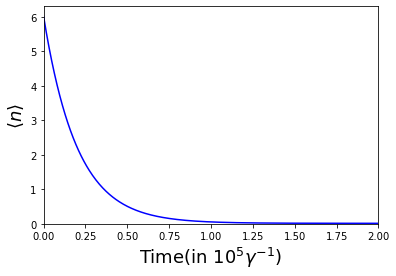

In [22]:
plt.plot(tlist/1e5*gamma,nbar_list(6),c="blue")
plt.xlabel(r"Time(in $10^5\gamma^{-1}$)",fontsize=18)
plt.ylabel(r"$\langle n \rangle$",fontsize=18)
plt.xlim(0,2)
plt.ylim(0)

## Master Equation

The absorption spectrum can be obtained by numerical solving the steady state solution of the master equationcorresponding to the Hamiltonian. The cooling speed can be calculated by solving the time evolution of the master equationcorresponding  to $\hat{H}_{\rm r}$ the cooling limit can be calculated by  the average phonon number of the steady statesolution of the master equation.

\begin{equation}
    \frac{d\hat\rho}{dt}=-i [\hat{H}_{\rm s},\hat \rho]+\mathcal{L}\rho,
\end{equation}

where $\mathcal{L}$ is the Lindblad operator corresponding to the three spontaneous decay channel  $\mathcal{L}\rho=\sum_{i\in \{g,r\}} c_i\rho c_i^\dagger-\frac{1}{2}[c_i^\dagger c_i,\rho]$ and $c_1=\sqrt{\Gamma/2}\left| r \right>\left< e \right|$, $c_2=\sqrt{\Gamma/2}\left| g \right>\left< e \right|$.

The Hamiltonian having a motional determined term

\begin{equation}
\hat{H}/\hbar=\begin{pmatrix}
\omega_{\left| e \right>}&-\frac{\Omega_\pi}{2}e^{-i(\vec{k}_{\rm p}\cdot\vec{r}-\omega_{\rm p}t)}&\frac{\Omega_{\sigma+}}{2}e^{-i(\vec{k}_{\rm d}\cdot\vec{r}-\omega_{\rm d}t)}\\
-\frac{\Omega_\pi}{2}e^{i(\vec{k}_{\rm p}\cdot\vec{r}-\omega_{\rm p}t)}&\omega_{\left| g \right>}& 0  \\
\frac{\Omega_{\sigma+}}{2}e^{i(\vec{k}_{\rm d}\cdot\vec{r}-\omega_{\rm d}t)}&0&\omega_{\left| r \right>}\\
\end{pmatrix}+\nu a^\dagger a, 
\end{equation}

where the basis is {$\left| e \right>$, $\left| r \right>$, $\left| g \right>$}. In the rotating frame the Hamiltonian can be simplified to 

\begin{equation}
\hat{H}_{\rm r}/\hbar=\begin{pmatrix}
0&-\frac{\Omega_\pi}{2}e^{-i\vec{k}_{\rm p}\cdot\vec{r}}&\frac{\Omega_{\sigma+}}{2}e^{-i\vec{k}_{\rm d}\cdot\vec{r}}\\
-\frac{\Omega_\pi}{2}e^{i\vec{k}_{\rm p}\cdot\vec{r}}&\Delta_{\rm g}&0\\
\frac{\Omega_{\sigma+}}{2}e^{i\vec{k}_{\rm d}\cdot\vec{r}}&0&\Delta_{\rm r}
\end{pmatrix}+\nu a^\dagger a.
\end{equation}

In [5]:
MaxPhonon = 12
e = basis(3,0)
g = basis(3,1)
r = basis(3,2)
def EITSimulationNoMotion(omega_g,omega_r,gamma,nu,detuning_g,detuning_r):
    #Hamiltonian
    Hhalf = (omega_g*g*e.dag()+omega_r*r*e.dag())/2
    delta_g = (np.sqrt(omega_g**2+detuning_g**2)-detuning_g)
    delta_r = (np.sqrt(omega_r**2+detuning_r**2)-detuning_r)
    H = Hhalf + Hhalf.dag() + detuning_g*g*g.dag()+ detuning_r*r*r.dag()

    #solve the steady state
    c_ops = [np.sqrt(gamma/2)*g*e.dag(),np.sqrt(gamma/2)*r*e.dag()]
    rho_ss = steadystate(H, c_ops, method='svd')
    return rho_ss

def EITSimulationWithIonMotion(omega_g,omega_r,gamma,nu,detuning_g,detuning_r,eta_sigma,eta_pi):
    #Hamiltonian
    Hhalf = (omega_g*tensor(g*e.dag(),(1j*eta_sigma*(create(MaxPhonon)+destroy(MaxPhonon))).expm())+omega_r*tensor(r*e.dag(),(1j*eta_pi*(create(MaxPhonon)+destroy(MaxPhonon))).expm()))/2
    H = Hhalf + Hhalf.dag() + detuning_g*tensor(g*g.dag(),qeye(MaxPhonon))+ detuning_r*tensor(r*r.dag(),qeye(MaxPhonon))+nu*tensor(qeye(3),create(MaxPhonon)*destroy(MaxPhonon))
    #solve the steady state
    c_ops = [np.sqrt(gamma/2)*tensor(g*e.dag(),qeye(MaxPhonon)),np.sqrt(gamma/2)*tensor(r*e.dag(),qeye(MaxPhonon))]
    rho_ss = steadystate(H, c_ops, method='svd')
    expect_op = tensor(qeye(3),create(MaxPhonon)*destroy(MaxPhonon))
    return expect(expect_op,rho_ss)
def TimeEvolutionOfPhonon(t, rho0, omega_g,omega_r,gamma,nu,detuning_g,detuning_r,eta_sigma,eta_pi):
    #Hamiltonian
    Hhalf = (omega_g*tensor(g*e.dag(),(1j*eta_sigma*(create(MaxPhonon)+destroy(MaxPhonon))).expm())+omega_r*tensor(r*e.dag(),(1j*eta_pi*(create(MaxPhonon)+destroy(MaxPhonon))).expm()))/2
    H = Hhalf + Hhalf.dag() + detuning_g*tensor(g*g.dag(),qeye(MaxPhonon))+ detuning_r*tensor(r*r.dag(),qeye(MaxPhonon))+nu*tensor(qeye(3),create(MaxPhonon)*destroy(MaxPhonon))
    #solve the steady state
    c_ops = [np.sqrt(gamma/2)*tensor(g*e.dag(),qeye(MaxPhonon)),np.sqrt(gamma/2)*tensor(r*e.dag(),qeye(MaxPhonon))]
    e_ops = [tensor(qeye(3),create(MaxPhonon)*destroy(MaxPhonon))]
    opts = Options(store_states=True,nsteps=5000)
    output = mesolve(H, rho0, t, c_ops, e_ops, options=opts)
    return output

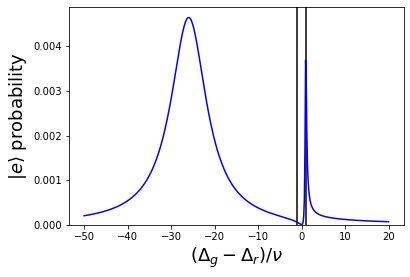

In [6]:
DeltaList = np.linspace(-50*nu,20*nu,500)
ExcitedStatePopulation = [np.abs(EITSimulationNoMotion(omega_g,omega_r,gamma,nu,detuning+Delta,detuning).full()[0,0]) for Delta in DeltaList]
plt.plot(DeltaList/nu,ExcitedStatePopulation,color="blue")
plt.xlabel(r"$(\Delta_g-\Delta_r)/\nu$",fontsize=18)
plt.ylabel(r"$|e\rangle$ probability",fontsize=18)
plt.ylim(0)
plt.vlines(-1,0,1)
plt.vlines(1,0,1)

In [7]:
ME_Ns = np.real(EITSimulationWithIonMotion(omega_g,omega_r,gamma,nu,detuning,detuning,eta/2,-eta/2))
RE_Ns = (Ap)/(Am-Ap)

In [8]:
rho0 = tensor(g,basis(MaxPhonon,6))
output=TimeEvolutionOfPhonon(tlist, rho0, omega_g,omega_r,gamma,nu,detuning,detuning,eta/2,-eta/2)

(0.0, 2.0)

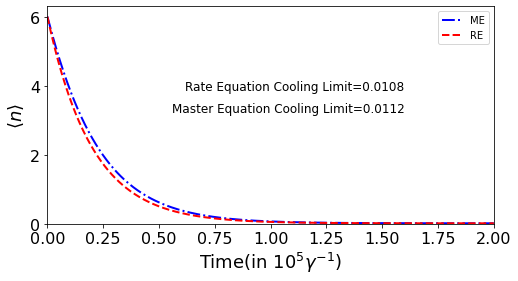

In [23]:
plt.figure(figsize=(8,4))
plt.plot(tlist/1e5*gamma,output.expect[0],c="blue",label="ME",linestyle="-.",linewidth=2)
plt.plot(tlist/1e5*gamma,nbar_list(6),c="red",linestyle="--",label="RE",linewidth=2)
plt.xlabel(r"Time(in $10^5\gamma^{-1}$)",fontsize=18)
plt.ylabel(r"$\langle n \rangle$",fontsize=18)
plt.annotate(r'Rate Equation Cooling Limit='+str(np.round(RE_Ns,4)), xy=(0.8,0.6),xycoords='axes fraction', fontsize=12,ha='right', va='bottom')
plt.annotate(r'Master Equation Cooling Limit='+str(np.round(ME_Ns,4)), xy=(0.8,0.5),xycoords='axes fraction', fontsize=12,ha='right', va='bottom')
plt.legend()
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.ylim(0)
plt.xlim(0,2)

# Thermal State

\begin{equation}
\text{Population}_{|\downarrow\rangle}(t) = \sum_{n=0}^{\infty}P_n\cos^2(\Omega_{n,n+1}t)e^{-\gamma_n t}
\end{equation}
where $P_n= (\frac{\bar{n}}{\bar{n}+1})^n(\frac{1}{\bar{n}+1})$

\begin{equation}
    \rho  = \sum_{n}(\frac{\langle n \rangle^n}{(\langle n \rangle+1)^{n+1}})|{n}\rangle\langle{n}|
\end{equation}

In [11]:
thermal_rho = tensor(ket2dm(g),thermal_dm(MaxPhonon,6))
thermal_output=TimeEvolutionOfPhonon(tlist, thermal_rho, omega_g,omega_r,gamma,nu,detuning,detuning,eta/2,-eta/2)

In [24]:
expect_op = tensor(qeye(3),create(MaxPhonon)*destroy(MaxPhonon))
nbar = float(expect(expect_op,thermal_rho))

(0.0, 2.0)

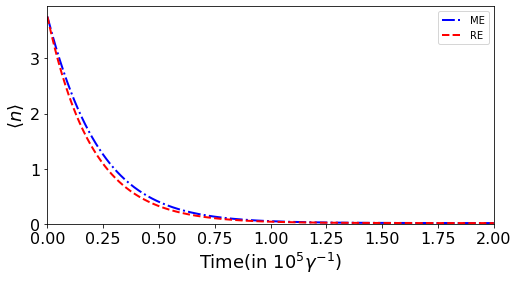

In [25]:
plt.figure(figsize=(8,4))
plt.plot(tlist/1e5*gamma,thermal_output.expect[0],c="blue",label="ME",linestyle="-.",linewidth=2)
plt.plot(tlist/1e5*gamma,nbar_list(nbar),c="red",linestyle="--",label="RE",linewidth=2)
plt.xlabel(r"Time(in $10^5\gamma^{-1}$)",fontsize=18)
plt.ylabel(r"$\langle n \rangle$",fontsize=18)
plt.legend()
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.ylim(0)
plt.xlim(0,2)